# Padaria Portugesa Geolocation

In [93]:
# classic import
import pandas as pd
from shapely.geometry import Polygon, Point
import geopandas as gp
import matplotlib.pyplot as plt

In [135]:
# open data and change projection to meters
freguesias = gp.read_file('data/freguesias.shp')
padarias = pd.read_csv('data/padarias.csv', index_col=0)
padarias.drop_duplicates(subset='restaurant.name', inplace=True)

In [136]:
freguesias = freguesias.to_crs('EPSG:3763')

C:\Users\Zaca\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [137]:
freguesias = freguesias[['NOME', 'AREA_M2', 'geometry']]

In [138]:
points = gp.GeoDataFrame(padarias, geometry=gp.points_from_xy(padarias['restaurant.location.longitude'], padarias['restaurant.location.latitude']))
points.crs = {'init' :'epsg:4326'}

points = points.to_crs('EPSG:3763')

C:\Users\Zaca\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [139]:
padarias

,restaurant.R.has_menu_status.delivery,restaurant.R.has_menu_status.takeaway,restaurant.R.res_id,restaurant.apikey,restaurant.id,restaurant.name,restaurant.url,restaurant.location.address,restaurant.location.locality,restaurant.location.city,...,restaurant.deeplink,restaurant.is_table_reservation_supported,restaurant.has_table_booking,restaurant.events_url,restaurant.phone_numbers,restaurant.all_reviews.reviews,restaurant.establishment,restaurant.establishment_types,restaurant.zomato_events,geometry
0,-1,-1,8202177,94974ff7db6ffeda0e1f9c75375ebca0,8202177,A Padaria Portuguesa - Duque D'Ávila,https://www.zomato.com/apadariaportuguesaduque...,"Avenida Duque D&#039;Ávila, 24A, Saldanha, Lisboa",Saldanha,Lisboa,...,zomato://restaurant/8202177,0,0,https://www.zomato.com/apadariaportuguesaduque...,926967076,"[{'review': []}, {'review': []}, {'review': []...",['Pastry Shop'],[],NaN,POINT (-9.14402 38.73503)
1,-1,-1,8200872,94974ff7db6ffeda0e1f9c75375ebca0,8200872,A Padaria Portuguesa - Camões,https://www.zomato.com/apadariaportuguesacamoe...,"Praça Luís de Camões, 44, Chiado, Lisboa",Chiado,Lisboa,...,zomato://restaurant/8200872,0,0,https://www.zomato.com/apadariaportuguesacamoe...,964930824,"[{'review': []}, {'review': []}, {'review': []...",['Pastry Shop'],[],NaN,POINT (-9.14321 38.71111)
2,-1,-1,8201909,94974ff7db6ffeda0e1f9c75375ebca0,8201909,A Padaria Portuguesa - Barata Salgueiro,https://www.zomato.com/apadariaportuguesabarat...,"Rua Mouzinho da Silveira, 2, Avenida da Liberd...",Avenida da Liberdade,Lisboa,...,zomato://restaurant/8201909,0,0,https://www.zomato.com/apadariaportuguesabarat...,967259104,"[{'review': []}, {'review': []}, {'review': []...",['Pastry Shop'],[],NaN,POINT (-9.14896 38.72159)
3,-1,-1,8201148,94974ff7db6ffeda0e1f9c75375ebca0,8201148,A Padaria Portuguesa - Campo de Ourique,https://www.zomato.com/apadariaportuguesacouri...,"Rua 4 de Infantaria, 30A, Campo de Ourique, Li...",Campo de Ourique,Lisboa,...,zomato://restaurant/8201148,0,0,https://www.zomato.com/apadariaportuguesacouri...,924450818,"[{'review': []}, {'review': []}, {'review': []...",['Pastry Shop'],[],NaN,POINT (-9.16477 38.71842)
4,-1,-1,8212526,94974ff7db6ffeda0e1f9c75375ebca0,8212526,A Padaria Portuguesa - António Augusto Aguiar,https://www.zomato.com/apadariaportuguesaaaagu...,"Avenida António Augusto Aguiar, 102, Praça de ...",Marquês de Pombal,Lisboa,...,zomato://restaurant/8212526,0,0,https://www.zomato.com/apadariaportuguesaaaagu...,961656249,"[{'review': []}, {'review': []}, {'review': []...",['Pastry Shop'],[],NaN,POINT (-9.15185 38.73190)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17,-1,-1,19279358,94974ff7db6ffeda0e1f9c75375ebca0,19279358,A Padaria Portuguesa - Residence,https://www.zomato.com/grande-lisboa/a-padaria...,"Avenida Fontes Pereira de Melo, 42E, Saldanha,...",Saldanha,Lisboa,...,zomato://restaurant/19279358,0,0,https://www.zomato.com/grande-lisboa/a-padaria...,967123174,[{'review': []}],['Pastry Shop'],[],NaN,POINT (-9.14566 38.73197)
18,-1,-1,18325349,94974ff7db6ffeda0e1f9c75375ebca0,18325349,A Padaria Portuguesa - Cacém,https://www.zomato.com/grande-lisboa/a-padaria...,"Avenida Bons Amigos, 7B, Cacém, Sintra",Cacém,Lisboa,...,zomato://restaurant/18325349,0,0,https://www.zomato.com/grande-lisboa/a-padaria...,962637535,"[{'review': []}, {'review': []}, {'review': []...",['Pastry Shop'],[],NaN,POINT (-9.29795 38.76839)
0,-1,-1,18657418,94974ff7db6ffeda0e1f9c75375ebca0,18657418,A Padaria Portuguesa - LAB,https://www.zomato.com/grande-lisboa/a-padaria...,"Avenida da República, 39",Campo Pequeno,Lisboa,...,zomato://restaurant/18657418,0,0,https://www.zomato.com/grande-lisboa/a-padaria...,"21 7931571, 969253277","[{'review': []}, {'review': []}, {'review': []...",['Pastry Shop'],[],NaN,POINT (-9.14600 38.73762)
6,-1,-1,19291119,94974ff7db6ffeda0e1f9c75375ebca0,19291119,A Padaria Portuguesa - Expo Sul,https://www.zomato.com/grande-lisboa/a-padaria...,"Avenida Dom João II, 14, Parque d

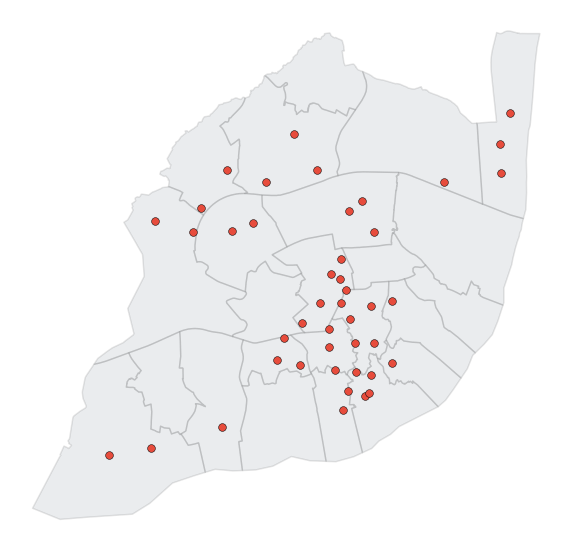

In [225]:
# remove points outside the city
points = points[points.geometry.within(freguesias.unary_union)]

base = freguesias.plot(figsize=(10, 10), facecolor='#34495e', edgecolor='black', linewidth= 1.5, alpha=.1)
points.plot(ax=base, marker='o', color='#e74c3c', markersize=60, edgecolor='k', linewidth=.5)
base.axis('off');

In [197]:
radius = gp.GeoSeries(points.buffer(500).unary_union)

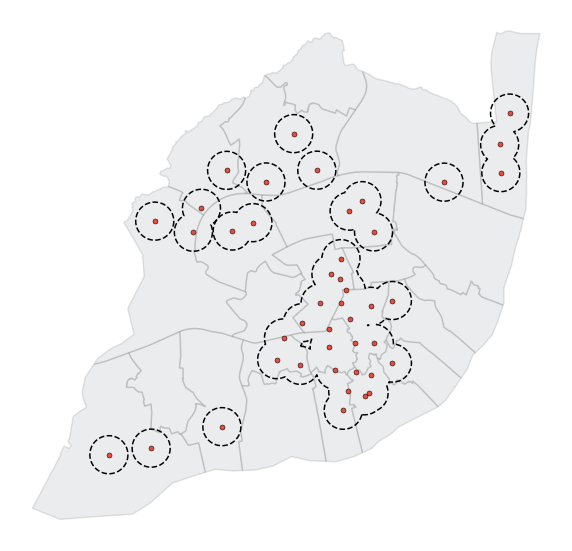

In [208]:
base = freguesias.plot(figsize=(10, 10), facecolor='#34495e', edgecolor='k', linewidth= 1.5, alpha=.1)
points.plot(ax=base, marker='o', color='#e74c3c', markersize=25, edgecolor='k', linewidth=.5)
base.axis('off');
radius.plot(ax=base, facecolor='none', edgecolor='k', lw=1.5, ls='dashed')

In [199]:
difference = gp.GeoSeries(radius.intersection(freguesias.unary_union))

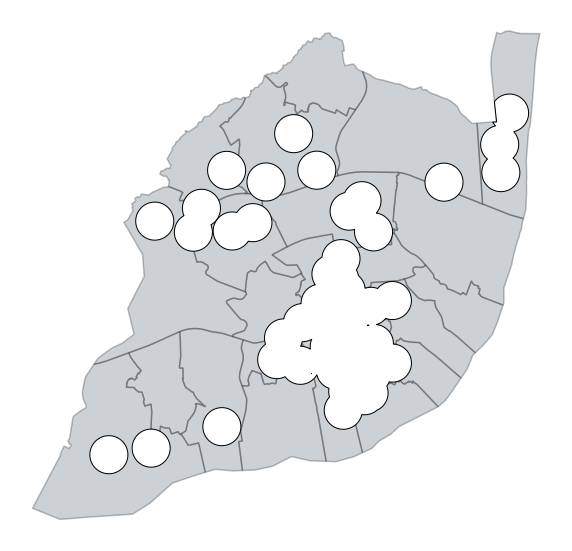

In [200]:
base = freguesias.plot(figsize=(10, 10), facecolor='#34495e', edgecolor='k', linewidth= 1.5, alpha=.25)
points.plot(ax=base, marker='o', color='#e74c3c', markersize=10, edgecolor='k', linewidth=.5)
base.axis('off');
difference.plot(ax=base, facecolor='white', edgecolor='k', lw=1)

In [215]:
difference = freguesias['geometry'].intersection(points.buffer(500).unary_union)

In [221]:
difference.area/freguesias.area

0     0.976288
1     0.392177
2     0.032862
3     0.002292
4     0.205692
5     0.402034
6     0.396081
7     0.149776
8     0.045984
9     0.950913
10    0.000000
11    0.673049
12    0.273405
13    0.417908
14    0.000000
15    0.186783
16    0.154517
17    0.677757
18    0.302871
19    0.068017
20    0.485132
21    0.351272
22    0.225042
23    0.171418
dtype: float64

In [220]:
freguesias.area

0     1.494327e+06
1     5.435099e+06
2     7.122471e+06
3     2.876605e+06
4     1.718990e+06
5     3.011546e+06
6     5.341700e+06
7     1.042680e+07
8     4.604012e+06
9     2.127850e+06
10    3.355540e+06
11    2.994491e+06
12    3.688787e+06
13    4.294350e+06
14    2.483757e+06
15    2.774335e+06
16    5.074760e+06
17    1.651379e+06
18    1.985833e+06
19    8.088233e+06
20    2.192160e+06
21    6.574870e+06
22    2.710739e+06
23    8.024437e+06
dtype: float64

In [222]:
freguesias.NOME

0               Santo António
1           Parque das Nações
2                     Marvila
3                       Ajuda
4                     Areeiro
5           Santa Maria Maior
6                    Alvalade
7                       Belém
8                     Estrela
9                     Arroios
10                Santa Clara
11             Avenidas Novas
12                    Carnide
13    São Domingos de Benfica
14                      Beato
15                  Campolide
16                  Alcântara
17           Campo de Ourique
18                São Vicente
19                    Olivais
20               Misericórdia
21                     Lumiar
22            Penha de França
23                    Benfica
Name: NOME, dtype: object